In [1]:
import torch
from torch.utils import data
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from importlib import reload

%matplotlib inline

In [2]:
# import the dataset and loader from data_utils.py
import data_utils

image_folder_path = "data/image"
SIDE = 64

batch_size = 32
# create a dataset so that dataset[i] returns the ith image
rl_data = data_utils.EmojiDataset(image_folder_path, (SIDE, SIDE))
# make a dataloader that returns the images as batches for parallel processing
rl_loader = data.DataLoader(rl_data, batch_size)
#DataLoader will create mini-batches, shuffle data each epoch, and offer performance boosts

In [3]:
import models

reload(models)

gen_in = 100
generator = models.Generator64(gen_in)
discriminator = models.Discrim64()

# use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = generator.to(device)
discriminator = discriminator.to(device)

In [4]:
# Initialize the loss function
criterion = torch.nn.BCELoss() #This is the loss specified in the GAN paper

# Create batch of latent vectors that we will use to visualize the progression of the generator
img_num = 25
fixed_noise = torch.randn(img_num, gen_in, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# set a learning rate
lr = 0.01

# Setup optimizers for both generator and discriminator
optim_d = torch.optim.AdamW(discriminator.parameters(), lr=lr)
optim_g = torch.optim.AdamW(generator.parameters(), lr=lr)

In [5]:
# functions that save and load the model and optimizer
save_to = "./checkpoints/model.pt"
def save(path, gen, disc, op_g, op_d):
    torch.save(
        {
            "generator_weights" : gen.state_dict(),
            "discriminator_weights" : disc.state_dict(),
            "generator_optimizer_weights" : op_g.state_dict(),
            "discriminator_optimizer_weights" : op_d.state_dict(),
        },
        path
    )


def load(path):
    # initialize 
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(path)
    gen = models.Generator64().to(dev)
    disc = models.Discrim64().to(dev)

    op_d = torch.optim.AdamW(gen.parameters(), lr=lr)
    op_g = torch.optim.AdamW(disc.parameters(), lr=lr)

    gen.load_state_dict(checkpoint["generator_weights"])
    disc.load_state_dict(checkpoint["discriminator_weights"])
    op_g.load_state_dict(checkpoint["generator_optimizer_weights"])
    op_d.load_state_dict(checkpoint["discriminator_optimizer_weights"])

    return gen, disc, op_g, op_d

In [6]:
generator.train()
discriminator.train()

rl_tensor = torch.full((batch_size, 1), real_label, device=device)
rl_rem_tensor = torch.full((len(rl_data) % batch_size, 1), real_label, device=device)

fk_tensor = torch.full((batch_size, 1), fake_label, device=device)
d_loss_stats = []
g_loss_stats = []
g_outputs = []

num_epochs = 100
for epoch in tqdm(range(1, num_epochs + 1)):
    for i, rl in enumerate(rl_loader):
        ########################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        #######################################################
        ## Train with all-real batch
        # Format batch
        rl = rl.to(device)

        # Forward pass real batch through D
        optim_d.zero_grad()
        output = discriminator(rl)

        # Calculate loss on all-real batch
        if output.shape[0] != batch_size:
            d_rl_loss = criterion(output, rl_rem_tensor)
        else:
            d_rl_loss = criterion(output, rl_tensor)

        ## Train with all-fake batch
        # Generate batch of latent vectors
        # shape: [batch size, channel #, side length, side length]
        latent_vec = torch.randn(batch_size, gen_in, 1, 1, device=device)

        # Generate fake image batch with G
        fake_img = generator(latent_vec)

        # Classify all fake batch with D
        output = discriminator(fake_img)

        # Calculate D's loss on the all-fake batch
        d_fk_loss = criterion(output, fk_tensor)

        # Compute error of D as sum over the fake and the real batches
        d_err = d_rl_loss + d_fk_loss
        d_err.backward(retain_graph=True)

        # Update D
        optim_d.step()

        ########################################################
        # (2) Update G network: maximize log(D(G(z)))
        #######################################################
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        optim_g.zero_grad()
        output = discriminator(fake_img)  # updated discriminator!

        # Calculate G's loss based on this output
        g_loss = criterion(output, rl_tensor)

        # Calculate gradients for G
        g_loss.backward()

        # Update G
        optim_g.step()


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

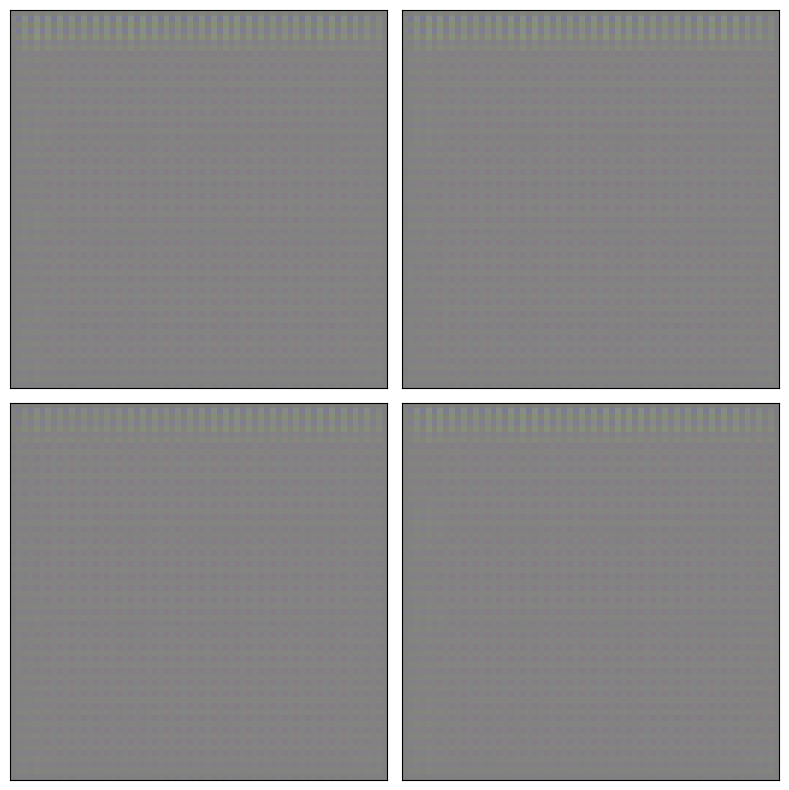

In [ ]:
# generate images from the model
gen_output = generator(fixed_noise)
side = int(img_num ** 0.5)
side = 2
fig, axes = plt.subplots(side, side, figsize=(8, 8))

for i in range(side):
    for j in range(side):
        img = (gen_output[side * i + j]).cpu().detach()
        img = torch.moveaxis(img, 0, 2)
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()